### Import libraries and global variables

In [1]:
import pandas

from ipywidgets import widgets, interact, fixed
from functools import wraps
from IPython import get_ipython
from IPython.display import display, HTML

from omero.gateway import BlitzGateway
from idr import create_http_session
from idr import genes_of_interest_go
from idr.widgets import textbox_widget
from idr.widgets import dropdown_widget
from idr import get_phenotypes_for_genelist, get_similar_genes

from idr.visualizations import plot_idr_attributes, plot_string_interactions
from idr.externalDBs import genes_of_interest_from_string

## Querying

### Variables:

In [11]:
organisms_list = ['Homo sapiens', 'Saccharomyces cerevisiae']
org_sel = dropdown_widget(organisms_list, 'Select Organism:', True)
tax_id = textbox_widget('9606', 'Enter Taxonomy Id for Organism',
                        "Taxonomy Id:", True)
go_term = textbox_widget('GO:0008290', 'Enter GO Id',
                         'Gene Ontology Id:', True)
manual_gene_list = textbox_widget('', 'Comma seperated gene symbols',
                                  'Manual Gene List:', True)

Dropdown(description=u'Select Organism:', options=('Homo sapiens', 'Saccharomyces cerevisiae'), value='Homo sapiens')

Text(value=u'9606', description=u'Taxonomy Id:', placeholder=u'Enter Taxonomy Id for Organism')

Text(value=u'', description=u'Gene Ontology Id:', placeholder=u'Enter GO Id from http://www.geneontology.org')

Text(value=u'', description=u'Manual Gene List:', placeholder=u'Comma seperated gene symbols')

### Import query list

In [12]:
go_gene_list = []
if go_term.value.split(",") != ['']:
    go_gene_list = genes_of_interest_go(go_term.value, tax_id.value)
else:
    print('Please enter a valid Gene Ontology Id')
manual_list = manual_gene_list.value.split(",")
if manual_list != ['']:
    go_gene_list = list(set(go_gene_list + manual_list))
print("Query list of genes:", go_gene_list)

Query list of genes: ['CAPZA3', 'CAPZA2', 'CAPZA1', 'ADD2', 'ADD1', 'CAPZB', 'HEL-S-86', 'MTPN', 'hCG_28646', 'CAPG']


### Query IDR for Phenotypes

In [13]:
session = create_http_session()
organism = org_sel.value

[query_genes_dataframe,
 screen_to_phenotype_dictionary] = get_phenotypes_for_genelist(session,
                                                               go_gene_list,
                                                               organism)
display(HTML(query_genes_dataframe.to_html(escape=False)))

,Entrez,Ensembl,Key,Value,PhenotypeName,PhenotypeAccession,ScreenIds
CAPZA3,[93661],[ENSG00000177938],GeneName,CAPZA3,"[misshapen DNA, elongated cell phenotype, fan-...","[CMPO_0000267, CMPO_0000274, CMPO_0000299, CMP...","[206, 206, 206, 206, 206, 206, 206, 206, 206, ..."
CAPZB,[832],[ENSG00000077549],GeneName,CAPZB,"[decreased cell numbers, fan-shaped lamellipod...","[CMPO_0000272, CMPO_0000288, CMPO_0000274, CMP...","[206, 206, 206, 206, 206, 206, 206, 206, 206, ..."
CAPZA1,[829],[ENSG00000116489],GeneName,CAPZA1,"[geometric cell phenotype, increased actin loc...","[CMPO_0000272, CMPO_0000288, CMPO_0000289, CMP...","[206, 206, 206, 206, 206, 206, 206, 206, 206, ..."
CAPG,[822],[ENSG00000042493],GeneName,CAPG,"[cell death phenotype, mitosis delayed phenoty...","[CMPO_0000305, CMPO_0000348, CMPO_0000307, CMP...","[1101, 1101, 1101, 1101, 1101, 1101, 1101, 1302]"


### Get Other Genes from the phenotypes

In [14]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)
try:
    query_genes_list = list(query_genes_dataframe['Value'])
    [similar_genes,
     overlap_genes] = get_similar_genes(conn, query_genes_list,
                                        screen_to_phenotype_dictionary)
    overlap_genes_dataframe = pandas.DataFrame.from_dict(overlap_genes,
                                                         orient='index')
    display(HTML("<strong>Query Genes:</strong>"))
    display(HTML(overlap_genes_dataframe.to_html(escape=False)))

    similar_genes_dataframe = pandas.DataFrame.from_dict(similar_genes,
                                                         orient='index')
    display(HTML("<strong>Similar Genes:</strong>"))
    display(HTML(similar_genes_dataframe.to_html(escape=False)))
finally:
    conn.close()

Connected to IDR...


,round cell phenotype,cell death phenotype,increased variability of nuclear shape in population,mitosis delayed phenotype,metaphase delayed phenotype,mitosis arrested,mitotic metaphase plate congression phenotype,abnormal cell cycle phenotype,metaphase arrested phenotype,polylobed nuclear phenotype,fan-shaped lamellipodia phenotype,increased variability of cell shape in population,increased lamellipodia width phenotype,misshapen DNA,geometric cell phenotype,increased actin localised to the cytoplasm,decreased nucleus size phenotype,increased microtubule-based processes phenotype,increased cell size phenotype,decreased cell numbers,elongated cell phenotype,increased amount of punctate actin foci phenotype,disorganised cortical actin cytoskeleton phenotype,increased cortical actin cytoskeleton mass phenotype,microtubules nuclear ring phenotype,increased amount of stress fibers phenotype,increased amount of zig-zag stress fibers,microtubules nuclear bracket phenotype,increased number of filopodia,more multinucleate cells,increased amount of transverse stress fibers,increased amount of stress fibers located in the cell cortex phenotype,star shaped cell phenotype,increased number of actin filament phenotype,loss of cell monolayer
1101,NaN,[CAPG],[CAPZB],[CAPG],[CAPG],[CAPG],[CAPG],[CAPG],[CAPG],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,[CAPZB],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[CAPG],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[CAPZA3, CAPZB]",[CAPZA3],"[CAPZA3, CAPZB]",[CAPZA3],[CAPZA1],"[CAPZB, CAPZA1]",[CAPZA1],"[CAPZA3, CAPZB]","[CAPZB, CAPZA1]",[CAPZB],[CAPZA3],"[CAPZA3, CAPZB]","[CAPZA3, CAPZB]","[CAPZB, CAPZA1]","[CAPZB, CAPZA1]","[CAPZA3, CAPZA1]",[CAPZA3],[CAPZA1],[CAPZB],[CAPZB],"[CAPZA3, CAPZA1]","[CAPZA3, CAPZA1]",[CAPZA3],"[CAPZB, CAPZA1]","[CAPZA3, CAPZB]"


,round cell phenotype,cell death phenotype,increased variability of nuclear shape in population,mitosis delayed phenotype,metaphase delayed phenotype,mitosis arrested,mitotic metaphase plate congression phenotype,abnormal cell cycle phenotype,metaphase arrested phenotype,polylobed nuclear phenotype,fan-shaped lamellipodia phenotype,increased variability of cell shape in population,increased lamellipodia width phenotype,misshapen DNA,geometric cell phenotype,increased actin localised to the cytoplasm,decreased nucleus size phenotype,increased microtubule-based processes phenotype,increased cell size phenotype,decreased cell numbers,elongated cell phenotype,increased amount of punctate actin foci phenotype,disorganised cortical actin cytoskeleton phenotype,increased cortical actin cytoskeleton mass phenotype,microtubules nuclear ring phenotype,increased amount of stress fibers phenotype,increased amount of zig-zag stress fibers,microtubules nuclear bracket phenotype,increased number of filopodia,more multinucleate cells,increased amount of transverse stress fibers,increased amount of stress fibers located in the cell cortex phenotype,star shaped cell phenotype,increased number of actin filament phenotype,loss of cell monolayer
1101,NaN,"[ENSG00000124209, ENSG00000134955, ZDHHC17, OR...","[, C1orf126, ENSG00000131183, ICK, PPAP2B, ENS...","[ENSG00000124209, , ASCC3L1, ENSG00000164542, ...","[ENSG00000124209, , ASCC3L1, MFAP1, ENSG000001...","[ENSG00000124209, , ASCC3L1, ENSG00000164542, ...","[ENSG00000124209, , ASCC3L1, ENSG00000148136, ...","[ENSG00000124209, , ASCC3L1, ENSG00000148136, ...","[ENSG00000124209, , ASCC3L1, MFAP1, ENSG000001...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202,"[, SYTL4, APBB1IP, IFLTD1, BTN3A1, CDX1, FLJ16...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[, UBL5, ENSG00000167513, CRISP2, ASCC3L1, NUF...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[C6ORF168, BAF53A, PTK2, CYFIP1, LOC201176, RR...","[C6ORF168, MAP4K3, PTK2, DMD, MYH15, RASD1, TM...","[BAF53A, ACTG1, MAP3K9, FMNL1, RAMP, ARHGAP27,...","[ACTG1, DTL, LOC201176, RAD51L3, FMN2, LASP1, ...","[C6ORF168, MAP4K3, TPM4, CYFIP1, ACTG1, RASD1,...","[RASD1, DTL, RHOT2, SPTBN1, TNNT3, LHX3, ECT2,...","[MINK1, MAP4K3, MINK, SVIL, MYH15, MYH4, WASF3...","[C6ORF168, BAF53A, PTK2, CYFIP1, LOC201176, MY...","[BAF53A, CYFIP1, ACTG1, RASD1, DTL, TMSB4X, MY...","[BAF53A, ACTG1, LASP1, MAP3K9, FMNL1, RAMP, AR...","[C6ORF168, BAF53A, PTK2, CYFIP1, MYH15, RASD1,...","[C6ORF168, BAF53A, PTK2, CYFIP1, MYH15, LOC201...","[BAF53A, MAP3K9, FMNL1, RAMP, ARHGAP27, ARHGAP...","[MAP4K3, TPM4, DMD, ACTG1, RASD1, LOC201176, M...","[MAP4K3, DMD, ACTG1, TMSB4X, MYO1F, SPTBN4, NC...","[C6ORF168, MAP4K3, CYFIP1, ACTG1, LOC201176, M...","[TPM4, CYFIP1, ACTG1, RASD1, DTL, LOC201176, M...","[EPB41L1, MINK1, MAP4K3, MINK, DBNL, MYH15, WD...","[BAF53A, CYFIP1, MYH15, RASD1, DTL, LOC201176,...","[BAF53A, PTK2, DMD, ACTG1, RASD1, DTL, LOC2011...","[MAP4K3, PTK2, CYFIP1, ACTG1, RASD1, MYO1F, RA...","[C6ORF168, MAP4K3, PTK2, CYFIP1, ACTG1, RASD1,...","[C6ORF168, BAF53A, PTK2, CYFIP1, LOC201176, RR...","[ACTG1, WDR1, DTL, RAMP, PTPN14, MYOHD1, CFL1,...","[C6ORF168, BAF53A, PTK2, DMD, MYH15, DTL, LOC2..."


## Visualization

### Plot Query Genes

In [15]:
%matplotlib inline
filter_by_category = widgets.Dropdown(description='Filter',
                                      options=['Phenotypes', 'Screens'])
threshold_for_category = widgets.IntSlider(description='Threshold',
                                           min=1, max=10, step=1, value=1)
threshold_for_plot = widgets.IntSlider(description='Threshold_for_plot',
                                       min=1, max=10, step=1, value=1)


@interact(primary_dictionary=fixed(overlap_genes),
          secondary_dictionary=fixed(overlap_genes),
          plot_title=fixed('Query Genes'),
          filter_by_category=filter_by_category,
          threshold_for_category=threshold_for_category,
          threshold_for_plot=threshold_for_plot)
@wraps(plot_idr_attributes)
def myfun(**kwargs):
    global screenids_removed, phenotypes_removed, genes_of_interest
    [screenids_removed, phenotypes_removed,
     genes_of_interest] = plot_idr_attributes(**kwargs)

interactive(children=(IntSlider(value=1, description=u'Threshold_for_plot', max=10, min=1), IntSlider(value=1, description=u'Threshold_for_category', max=10, min=1), Dropdown(description=u'Filter_by_category', options=('Phenotypes', 'Screens'), value='Phenotypes'), Output()), _dom_classes=('widget-interact',))

### Plot Similar Genes

In [16]:
for ids in screenids_removed:
    if ids in similar_genes:
        del similar_genes[ids]


@interact(primary_dictionary=fixed(similar_genes),
          secondary_dictionary=fixed(overlap_genes),
          plot_title=fixed('Similar genes'),
          filter_by_category=fixed(filter_by_category.value),
          threshold_for_category=fixed(threshold_for_category.value),
          threshold_for_plot=widgets.IntSlider(min=1, max=10, step=1, value=5))
@wraps(plot_idr_attributes)
def myfun2(**kwargs):
    global screenids_removed, phenotypes_removed, genes_of_interest
    [screenids_removed, phenotypes_removed,
     genes_of_interest] = plot_idr_attributes(**kwargs)


similar_genes_list = genes_of_interest

interactive(children=(IntSlider(value=5, description=u'threshold_for_plot', max=10, min=1), Output()), _dom_classes=('widget-interact',))

### Get String Interactions

### Plot interactions between similar genes and query genes/similar genes

Primary Interactors:


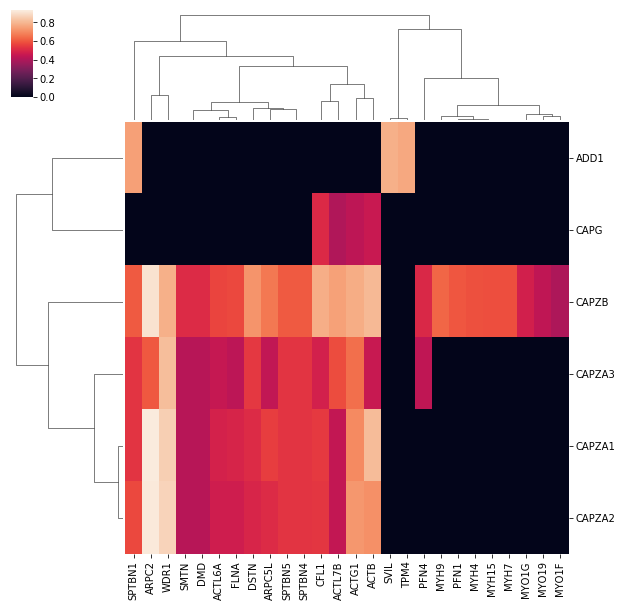

Secondary Interactors:


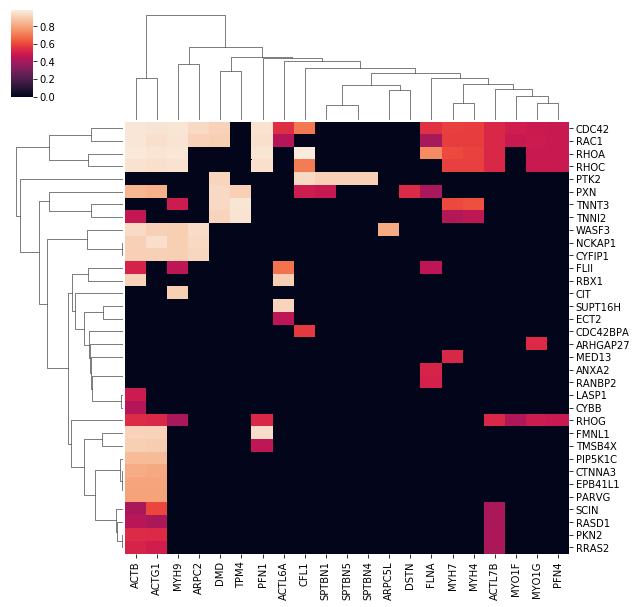

In [17]:
similar_genes_list = list(set(genes_of_interest) - set(go_gene_list))
genes_of_interest1 = list(set(go_gene_list + similar_genes_list))
interactions_dataframe = genes_of_interest_from_string(genes_of_interest1,
                                                       1, tax_id.value)

print('Primary Interactors:')
df = plot_string_interactions(go_gene_list, similar_genes_list,
                              interactions_dataframe)

primary_genes = list(df.columns.values)
secondary_genes = set(similar_genes_list) - set(primary_genes)
print('Secondary Interactors:')
df = plot_string_interactions(secondary_genes, primary_genes,
                              interactions_dataframe)

### License
Copyright (C) 2016-2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.